<span style="color:green">

**Note:** All figures and their analysis are presented in the accompanying report `Report.pdf`.

</span>


In [105]:
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchvision.models import resnet18
import pickle
import os
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
from sklearn.decomposition import PCA
from openood.evaluation_api import Evaluator
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from scipy.stats import pearsonr

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #32x32 -> 40x40 -> 32x32
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), #PIL to tensor
    transforms.Normalize(#apprently help to converge.
        mean=[0.5071, 0.4867, 0.4408], 
        std=[0.2675, 0.2565, 0.2761]
    ),
])#help the model to be more robust

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761] #necessary to have the same kind of data for evaluation
    ),
])

In [6]:

trainset = torchvision.datasets.CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

testset = torchvision.datasets.CIFAR100(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

trainloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=8)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
model = resnet18(weights=None)  # pas ImageNet pretrained

#H_out = (H + 2p − k) / s + 1
#Donc sans toucher H_out = (32 + 2x3 - 7) / 2  + 1 = 16 
#Puis avec le max pool on tombe à 8. 
# Très génant car les canaux stocknte des motifs mais pas la position, donc en passant de 32 à 8 on "flouterai" enormement l'image

# Modifie la première couche pour prendre du 32x32
model.conv1 = nn.Conv2d(
    3, 64, kernel_size=3, stride=1, padding=1, bias=False
)
model.maxpool = nn.Identity() #out = 64x32x32 bien mieux que 64x8x8

# Modifier la dernière couche pour avoir 100 classes
model.fc = nn.Linear(512, 100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)

Device: cuda


In [8]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.0015, #0.005 -> 0.003 -> 0.0015
    momentum=0.9,
    weight_decay=5e-4
)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[70, 80],
    gamma=0.1
)

In [9]:
def train_one_epoch(model, loader):
    model.train()
    correct, total, running_loss = 0, 0, 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100. * correct / total
    return running_loss / len(loader), acc


In [11]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return 100. * correct / total

In [145]:
checkpoint = torch.load("checkpoints/best.pth")

model.load_state_dict(checkpoint["model_state"])
#optimizer.load_state_dict(checkpoint["optimizer_state"])
#scheduler.load_state_dict(checkpoint["scheduler_state"])

start_epoch = checkpoint["epoch"]
model = model.to(device)

C:\Users\mathi\AppData\Local\Temp\ipykernel_9552\67857274.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoints/best.pth")


In [146]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [13]:
model = model.to(device)

train_losses = checkpoint["train_losses"]
train_accs = checkpoint["train_accs"]
test_accs = checkpoint["test_accs"]

In [28]:
train_accs, test_accs, train_losses = [], [], []

In [63]:
num_epochs = 200

save_every = 10
os.makedirs("checkpoints", exist_ok=True)
torch.backends.cudnn.benchmark = True
best_acc = -1.0

for epoch in range(start_epoch, num_epochs):
    train_loss, train_acc = train_one_epoch(model, trainloader)
    test_acc = evaluate(model, testloader)
    scheduler.step()

    train_accs.append(train_acc)
    test_accs.append(test_acc)
    train_losses.append(train_loss)

    if test_acc > best_acc:
        checkpoint = {
            "epoch": epoch + 1,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "train_losses": train_losses,
            "train_accs": train_accs,
            "test_accs": test_accs,
        }
        best_acc = test_acc
        torch.save(checkpoint, "checkpoints/best.pth")
    #sauvegarde périodique
    if (epoch + 1) % save_every == 0:
        checkpoint = {
            "epoch": epoch + 1,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "train_losses": train_losses,
            "train_accs": train_accs,
            "test_accs": test_accs,
        }
        torch.save(checkpoint, f"checkpoints/checkpoint_epoch_{epoch+1}.pth")

    print(f"Epoch {epoch:03d} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

torch.save(model.state_dict(), "resnet18_cifar100.pth")

history = {
    "train_losses": train_losses,
    "train_accs": train_accs,
    "test_accs": test_accs
}

with open("training_history.pkl", "wb") as f:
    pickle.dump(history, f)

Epoch 082 | Train Acc: 99.96% | Test Acc: 76.02%
Epoch 083 | Train Acc: 99.97% | Test Acc: 75.99%
Epoch 084 | Train Acc: 99.96% | Test Acc: 76.13%
Epoch 085 | Train Acc: 99.96% | Test Acc: 76.13%
Epoch 086 | Train Acc: 99.96% | Test Acc: 76.31%
Epoch 087 | Train Acc: 99.96% | Test Acc: 76.24%
Epoch 088 | Train Acc: 99.97% | Test Acc: 76.32%
Epoch 089 | Train Acc: 99.95% | Test Acc: 76.28%
Epoch 090 | Train Acc: 99.97% | Test Acc: 76.32%
Epoch 091 | Train Acc: 99.96% | Test Acc: 76.20%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001848601D2D0>
Traceback (most recent call last):
  File "c:\Users\mathi\miniconda3\envs\ME\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\mathi\miniconda3\envs\ME\lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001848601D2D0>
Traceback (most recent call last):
  File "c:\Users\mathi\miniconda3\envs\ME\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\mathi\miniconda3\envs\ME\lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._work

KeyboardInterrupt: 

In [140]:
checkpoint = torch.load("checkpoints/best.pth")

model.load_state_dict(checkpoint["model_state"])
model.eval().to(device)

C:\Users\mathi\AppData\Local\Temp\ipykernel_9552\1937691237.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoints/best.pth")


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [15]:
preprocessor = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])

In [ ]:

methods = [
    "energy",
    "odin",
    "maxlogit"
]

all_metrics = {}

for m in methods:
    evaluator = Evaluator(
        net=model,
        id_name="cifar100",          
        preprocessor=preprocessor,  
        postprocessor_name=m
    )
    metrics = evaluator.eval_ood()  
    all_metrics[m] = metrics
    print(m, metrics) 
    #OpenOOD n'est pas à jour, les liens ont changés

HTTPError: HTTP Error 404: Not Found

In [132]:
ood_cifar10 = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform_test
)

ood_svhn = torchvision.datasets.SVHN(
    root="./data",
    split="test",
    download=True,
    transform=transform_test
)

ood_cifar10_loader = DataLoader(ood_cifar10, batch_size=256, shuffle=False, num_workers=8)
ood_svhn_loader = DataLoader(ood_svhn, batch_size=256, shuffle=False, num_workers=8)

testset_q3 = torchvision.datasets.CIFAR100(
    root="./data",
    train=False,
    transform=transform_test
)
testloader_q3 = DataLoader(testset_q3, batch_size=256, shuffle=False, num_workers=8)

# TRAIN (pour stats seulement, sans augmentation)
trainset_q3 = torchvision.datasets.CIFAR100(
    root="./data",
    train=True,
    transform=transform_test  
)
trainloader_q3 = DataLoader(trainset_q3, batch_size=256, shuffle=False, num_workers=8)

Files already downloaded and verified
Using downloaded and verified file: ./data\test_32x32.mat


In [26]:
@torch.no_grad()
def collect_logits(model, loader):
    logits = []
    for x, _ in loader:
        x = x.to(device)
        logits.append(model(x).cpu())
    return torch.cat(logits)


In [133]:
@torch.no_grad()
def collect_features(model, loader):
    feats = []
    labels = []
    for x, y in loader:
        x = x.to(device)

        z = model.conv1(x)
        z = model.bn1(z)
        z = model.relu(z)
        z = model.maxpool(z)
        z = model.layer1(z)
        z = model.layer2(z)
        z = model.layer3(z)
        z = model.layer4(z)
        z = model.avgpool(z)
        z = torch.flatten(z, 1)

        feats.append(z.cpu())

        labels.append(y)

    return torch.cat(feats), torch.cat(labels)

In [28]:
def score_msp(logits):
    return (-F.softmax(logits, dim=1).max(dim=1).values).numpy()

In [29]:
def score_maxlogit(logits):
    return (-logits.max(dim=1).values).numpy()

In [30]:
def score_energy(logits):
    return (-torch.logsumexp(logits, dim=1)).numpy()

In [135]:
def fit_mahalanobis(features, labels, num_classes=100):
    X = features.numpy()
    y = labels.numpy()

    dim = X.shape[1]
    mus = np.zeros((num_classes, dim))

    for c in range(num_classes):
        mus[c] = X[y == c].mean(axis=0)

    Xc = X - mus[y]
    cov = np.cov(Xc, rowvar=False)
    cov += 1e-4 * np.eye(dim)
    inv_cov = np.linalg.inv(cov)

    return mus, inv_cov

In [134]:
def score_mahalanobis(features, mus, inv_cov):
    X = features.numpy()
    dists = []
    for c in range(mus.shape[0]):
        diff = X - mus[c]
        d = np.einsum("nd,dd,nd->n", diff, inv_cov, diff)
        dists.append(d)
    return np.min(np.stack(dists, axis=1), axis=1)

In [136]:
def fit_vim(train_feats, dim=64):
    pca = PCA(n_components=dim)
    pca.fit(train_feats)
    U = pca.components_
    U_orth = np.eye(train_feats.shape[1]) - U.T @ U
    return U_orth

In [35]:
def score_vim(logits, features, U_orth, alpha=1.0):
    energy = score_energy(logits)
    proj = np.linalg.norm(features.numpy() @ U_orth, axis=1)
    return energy + alpha * proj

In [36]:
def fpr_at_95(y, s):
    fpr, tpr, _ = roc_curve(y, s)
    return fpr[np.argmin(np.abs(tpr - 0.95))]

def eval_ood(id_scores, ood_scores):
    y = np.concatenate([np.zeros_like(id_scores), np.ones_like(ood_scores)])
    s = np.concatenate([id_scores, ood_scores])
    return {
        "AUROC": roc_auc_score(y, s),
        "AUPR": average_precision_score(y, s),
        "FPR@95": fpr_at_95(y, s),
    }

In [130]:
train_feats, _ = collect_features(model, trainloader_q3)
train_labels = torch.tensor(trainset_q3.targets)

# Mahalanobis
mus, inv_cov = fit_mahalanobis(train_feats, train_labels)

# ViM
U_orth = fit_vim(train_feats.numpy())

In [153]:
id_logits = collect_logits(model, testloader_q3)
id_feats, _  = collect_features(model, testloader_q3)

ood_logits = collect_logits(model, ood_cifar10_loader)
ood_feats, _  = collect_features(model, ood_cifar10_loader)

results_cifar10 = {
    "MSP": eval_ood(score_msp(id_logits), score_msp(ood_logits)),
    "MaxLogit": eval_ood(score_maxlogit(id_logits), score_maxlogit(ood_logits)),
    "Energy": eval_ood(score_energy(id_logits), score_energy(ood_logits)),
    "Mahalanobis": eval_ood(
        score_mahalanobis(id_feats, mus, inv_cov),
        score_mahalanobis(ood_feats, mus, inv_cov)
    ),
    "ViM": eval_ood(
        score_vim(id_logits, id_feats, U_orth),
        score_vim(ood_logits, ood_feats, U_orth)
    )
}

In [142]:
def plot_roc(id_scores, ood_scores, label):
    y = np.concatenate([np.zeros_like(id_scores), np.ones_like(ood_scores)])
    s = np.concatenate([id_scores, ood_scores])
    fpr, tpr, _ = roc_curve(y, s)
    plt.plot(fpr, tpr, label=label)

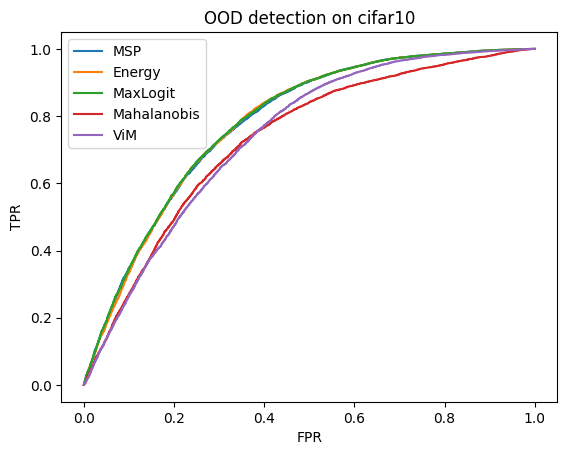

In [143]:
plt.figure()
plot_roc(score_msp(id_logits), score_msp(ood_logits), "MSP")
plot_roc(score_energy(id_logits), score_energy(ood_logits), "Energy")
plot_roc(score_maxlogit(id_logits), score_maxlogit(ood_logits), "MaxLogit")
plot_roc(
    score_mahalanobis(id_feats, mus, inv_cov),
    score_mahalanobis(ood_feats, mus, inv_cov),
    "Mahalanobis"
)
plot_roc(
    score_vim(id_logits, id_feats, U_orth),
    score_vim(ood_logits, ood_feats, U_orth),
    "ViM"
)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.title("OOD detection on cifar10")
os.makedirs("results/img", exist_ok=True)
plt.savefig("results/img/OOD_cifar10")
plt.show()

In [148]:
ood_logits = collect_logits(model, ood_svhn_loader)
ood_feats, _  = collect_features(model, ood_svhn_loader)

results_svhn = {
    "MSP": eval_ood(score_msp(id_logits), score_msp(ood_logits)),
    "MaxLogit": eval_ood(score_maxlogit(id_logits), score_maxlogit(ood_logits)),
    "Energy": eval_ood(score_energy(id_logits), score_energy(ood_logits)),
    "Mahalanobis": eval_ood(
        score_mahalanobis(id_feats, mus, inv_cov),
        score_mahalanobis(ood_feats, mus, inv_cov)
    ),
    "ViM": eval_ood(
        score_vim(id_logits, id_feats, U_orth),
        score_vim(ood_logits, ood_feats, U_orth)
    )
}

In [43]:
df_svhn = pd.DataFrame(results_svhn).T
df_svhn

,AUROC,AUPR,FPR@95
MSP,0.818914,0.892777,0.4944
MaxLogit,0.820560,0.892810,0.4832
Energy,0.816240,0.887179,0.4778
Mahalanobis,0.819037,0.890681,0.5268
ViM,0.910182,0.954553,0.3652


In [44]:
df_cifar = pd.DataFrame(results_cifar10).T
df_cifar

,AUROC,AUPR,FPR@95
MSP,0.780883,0.736702,0.6125
MaxLogit,0.782357,0.737780,0.6121
Energy,0.781018,0.733601,0.6114
Mahalanobis,0.748398,0.702395,0.7298
ViM,0.735324,0.680681,0.6755


In [51]:
os.makedirs("results", exist_ok=True)
df_svhn.to_csv('results/results_svhn.csv', index=True)
df_cifar.to_csv('results/results_cifar.csv', index=True)

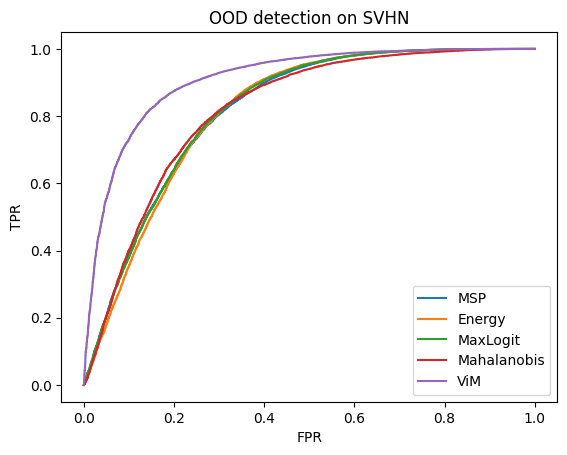

In [ ]:
plt.figure()
plot_roc(score_msp(id_logits), score_msp(ood_logits), "MSP")
plot_roc(score_energy(id_logits), score_energy(ood_logits), "Energy")
plot_roc(score_maxlogit(id_logits), score_maxlogit(ood_logits), "MaxLogit")
plot_roc(
    score_mahalanobis(id_feats, mus, inv_cov),
    score_mahalanobis(ood_feats, mus, inv_cov),
    "Mahalanobis"
)
plot_roc(
    score_vim(id_logits, id_feats, U_orth),
    score_vim(ood_logits, ood_feats, U_orth),
    "ViM"
)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.title("OOD detection on SVHN")
os.makedirs("results/img", exist_ok=True)
plt.savefig("results/img/OOD_SVHN")
plt.show()

In [ ]:


plt.figure()
plot_roc(score_msp(id_logits), score_msp(ood_logits), "MSP")
plot_roc(score_energy(id_logits), score_energy(ood_logits), "Energy")
plot_roc(
    score_vim(id_logits, id_feats, U_orth),
    score_vim(ood_logits, ood_feats, U_orth),
    "ViM"
)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.title("OOD detection on SVHN")
os.makedirs("results/img", exist_ok=True)
plt.savefig("results/img/OOD_SVHN")
plt.show()

Question 4

In [67]:
features, labels = collect_features(model, trainloader_q3)
features = features.numpy()
labels = labels.numpy()

NC1

In [68]:
num_classes = 100
feat_dim = features.shape[1]

# moyennes de classe
mus = np.zeros((num_classes, feat_dim))
for c in range(num_classes):
    mus[c] = features[labels == c].mean(axis=0)

# covariance intra-classe
Sw = np.zeros((feat_dim, feat_dim))
for c in range(num_classes):
    Xc = features[labels == c] - mus[c]
    Sw += Xc.T @ Xc
Sw /= features.shape[0]

# covariance totale
mu_global = features.mean(axis=0)
Xt = features - mu_global
St = (Xt.T @ Xt) / features.shape[0]

nc1_ratio = np.trace(Sw) / np.trace(St)
print("NC1 (trace ratio):", nc1_ratio)

NC1 (trace ratio): 0.28863054926902604


In [81]:
def computeNC1(features, labels, num_classes = 100):
    feat_dim = features.shape[1]

    # moyennes de classe
    mus = np.zeros((num_classes, feat_dim))
    for c in range(num_classes):
        mus[c] = features[labels == c].mean(axis=0)

    # covariance intra-classe
    Sw = np.zeros((feat_dim, feat_dim))
    for c in range(num_classes):
        Xc = features[labels == c] - mus[c]
        Sw += Xc.T @ Xc
    Sw /= features.shape[0]

    # covariance totale
    mu_global = features.mean(axis=0)
    Xt = features - mu_global
    St = (Xt.T @ Xt) / features.shape[0]

    nc1_ratio = np.trace(Sw) / np.trace(St)
    return nc1_ratio, mus, mu_global

NC2

In [77]:
M = mus - mu_global
M = normalize(M)

cos_sim = M @ M.T

# on enlève la diagonale
off_diag = cos_sim[~np.eye(num_classes, dtype=bool)]

print("NC2 mean cosine:", off_diag.mean())
print("NC2 std cosine :", off_diag.std())


NC2 mean cosine: -0.010076652274102874
NC2 std cosine : 0.05150913053322345


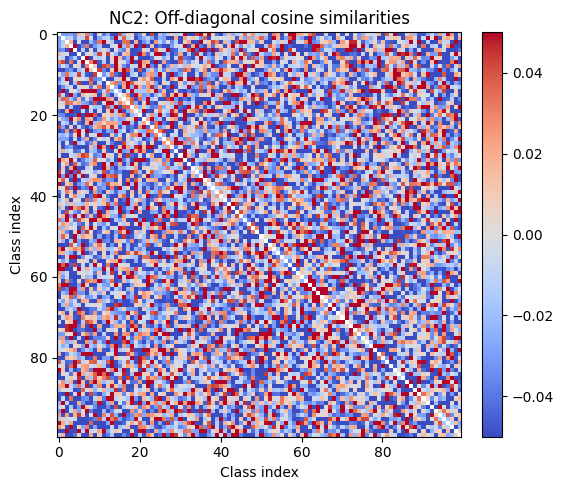

In [78]:
cos_no_diag = cos_sim.copy()
np.fill_diagonal(cos_no_diag, np.nan)

plt.figure(figsize=(6, 5))
im = plt.imshow(cos_no_diag, cmap="coolwarm", vmin=-0.05, vmax=0.05)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("NC2: Off-diagonal cosine similarities")
plt.xlabel("Class index")
plt.ylabel("Class index")
plt.tight_layout()
plt.show()

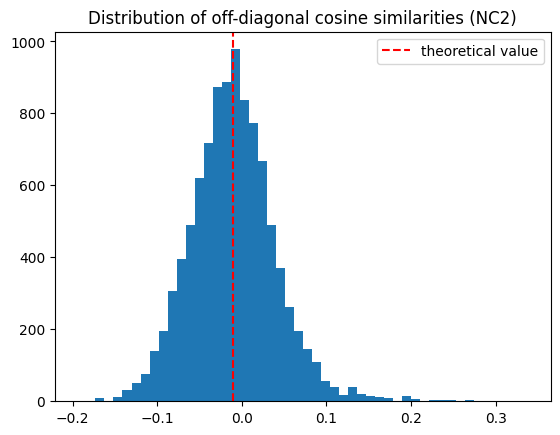

In [79]:
off_diag = cos_sim[~np.eye(cos_sim.shape[0], dtype=bool)]

plt.figure()
plt.hist(off_diag, bins=50)
plt.axvline(-1/99, color='r', linestyle='--', label='theoretical value')
plt.title("Distribution of off-diagonal cosine similarities (NC2)")
plt.legend()
plt.show()

In [82]:
def computeNC2(mus, mu_global, num_classes):
    M = mus - mu_global
    M = normalize(M)

    cos_sim = M @ M.T

    # on enlève la diagonale
    off_diag = cos_sim[~np.eye(num_classes, dtype=bool)]
    return off_diag.mean(), off_diag.std(), cos_sim

NC3

In [71]:
W = model.fc.weight.detach().cpu().numpy()
W = normalize(W)
M = normalize(mus)

alignment = np.sum(W * M, axis=1)

print("NC3 mean alignment:", alignment.mean())
print("NC3 std alignment :", alignment.std())

NC3 mean alignment: 0.7196801050795888
NC3 std alignment : 0.03715547851980092


In [74]:
def computeNC3(model, mus):
    W = model.fc.weight.detach().cpu().numpy()
    W = normalize(W)
    M = normalize(mus)

    alignment = np.sum(W * M, axis=1)
    return alignment.mean(), alignment.std()

NC4

In [ ]:
@torch.no_grad()
def nearest_mean_accuracy(features, labels, mus):
    dists = []
    for c in range(mus.shape[0]):
        diff = features - mus[c]
        dists.append(np.sum(diff**2, axis=1))
    preds = np.argmin(np.stack(dists, axis=1), axis=1)
    return (preds == labels).mean()

nm_acc = nearest_mean_accuracy(features, labels, mus)
print("NC4 Nearest-Mean accuracy:", nm_acc)

NC4 Nearest-Mean accuracy: 0.99964


In [84]:
def compute_NC(model):
    num_classes = 100
    features, labels = collect_features(model, trainloader_q3)
    features = features.numpy()
    labels = labels.numpy()
    nc1, mus, mu_global = computeNC1(features=features, labels=labels)
    nc2_mean, nc2_std, cos_sim = computeNC2(mus=mus, mu_global=mu_global, num_classes=num_classes)
    nc3_mean, nc3_std = computeNC3(model, mus)
    nc4 = nearest_mean_accuracy(features=features, labels=labels, mus=mus)

    return {"nc1": nc1, "nc2_mean": nc2_mean, "nc2_std": nc2_std, "nc3_mean": nc3_mean, "nc3_std": nc3_std, "nc4": nc4}

In [85]:
res = {}
for i in range(1, 10):
    model = resnet18(weights=None)  # pas ImageNet pretrained

    model.conv1 = nn.Conv2d(
        3, 64, kernel_size=3, stride=1, padding=1, bias=False
    )
    model.maxpool = nn.Identity() 

    model.fc = nn.Linear(512, 100)
    checkpoint = torch.load(f"checkpoints/checkpoint_epoch_{i}0.pth")

    model.load_state_dict(checkpoint["model_state"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    resi = compute_NC(model)
    res[f"epoch {i}0"] = resi
    
res_df = pd.DataFrame(res)

C:\Users\mathi\AppData\Local\Temp\ipykernel_9552\2822022058.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"checkpoints/checkpoint_epoch_{i}0.

In [90]:
model = resnet18(weights=None)  # pas ImageNet pretrained

model.conv1 = nn.Conv2d(
    3, 64, kernel_size=3, stride=1, padding=1, bias=False
)
model.maxpool = nn.Identity() 

model.fc = nn.Linear(512, 100)
checkpoint = torch.load(f"checkpoints/best.pth")

model.load_state_dict(checkpoint["model_state"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
resi = compute_NC(model)

C:\Users\mathi\AppData\Local\Temp\ipykernel_9552\3888858752.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"checkpoints/best.pth")


In [ ]:
res_df["best"] = resi

In [93]:
res_df

,epoch 10,epoch 20,epoch 30,epoch 40,epoch 50,epoch 60,epoch 70,epoch 80,epoch 90,best
nc1,0.581548,0.538191,0.525994,0.523629,0.503568,0.499098,0.461780,0.390258,0.368160,0.369207
nc2_mean,-0.006925,-0.008784,-0.008981,-0.009048,-0.009310,-0.009623,-0.010004,-0.010012,-0.010025,-0.010027
nc2_std,0.244242,0.206000,0.191405,0.178504,0.173263,0.173827,0.071368,0.065374,0.056907,0.057190
nc3_mean,0.469175,0.538724,0.569559,0.579154,0.596106,0.607016,0.609644,0.677879,0.685932,0.685642
nc3_std,0.043822,0.049393,0.056179,0.058486,0.061298,0.054356,0.051930,0.051484,0.047100,0.046656
nc4,0.617200,0.750600,0.810640,0.834220,0.856480,0.861180,0.974240,0.976080,0.978580,0.978440


In [94]:
res_df.to_csv('results/nc.csv', index=True)

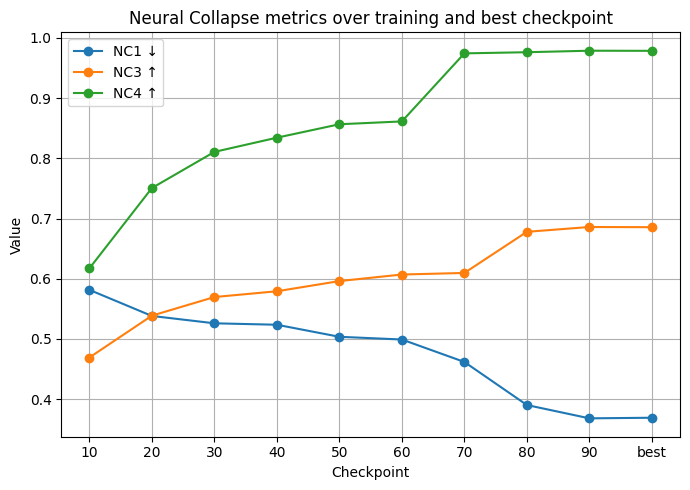

In [102]:
epochs = [10,20,30,40,50,60,70,80,90]
epochs_ext = epochs + ["best"]

nc1 = [0.5815,0.5382,0.5260,0.5236,0.5036,0.4991,0.4618,0.3903,0.3682,0.3692]
nc3 = [0.4692,0.5387,0.5696,0.5792,0.5961,0.6070,0.6096,0.6779,0.6859,0.6856]
nc4 = [0.6172,0.7506,0.8106,0.8342,0.8565,0.8612,0.9742,0.9761,0.9786,0.9784]

plt.figure(figsize=(7,5))
plt.plot(range(len(epochs_ext)), nc1, marker='o', label="NC1 ↓")
plt.plot(range(len(epochs_ext)), nc3, marker='o', label="NC3 ↑")
plt.plot(range(len(epochs_ext)), nc4, marker='o', label="NC4 ↑")
plt.xticks(range(len(epochs_ext)), epochs_ext)
plt.xlabel("Checkpoint")
plt.ylabel("Value")
plt.title("Neural Collapse metrics over training and best checkpoint")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/img/NC134.png")
plt.show()

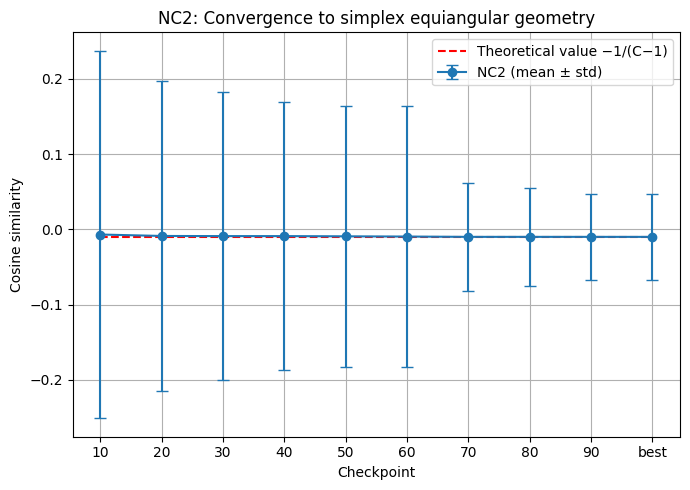

In [101]:
epochs = [10,20,30,40,50,60,70,80,90,"best"]

nc2_mean = [-0.0069,-0.0088,-0.0090,-0.0090,-0.0093,-0.0096,-0.0100,-0.0100,-0.0100,-0.01003]
nc2_std  = [0.2442,0.2060,0.1914,0.1785,0.1733,0.1738,0.0714,0.0654,0.0569,0.0572]

theory = [-1/99]*len(epochs)

plt.figure(figsize=(7,5))
plt.errorbar(range(len(epochs)), nc2_mean, yerr=nc2_std,
             fmt='o-', capsize=4, label="NC2 (mean ± std)")
plt.plot(range(len(epochs)), theory, 'r--', label="Theoretical value −1/(C−1)")
plt.xticks(range(len(epochs)), epochs)
plt.xlabel("Checkpoint")
plt.ylabel("Cosine similarity")
plt.title("NC2: Convergence to simplex equiangular geometry")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/img/NC2.png")
plt.show()

Question 5 : NC5

In [107]:
id_feats, id_labels = collect_features(model, trainloader_q3)

ood_feats_svhn, _ = collect_features(model, ood_svhn_loader)
ood_feats_c10, _  = collect_features(model, ood_cifar10_loader)

In [109]:
def compute_class_means(feats, labels, num_classes=100):
    mus = []
    for c in range(num_classes):
        mus.append(feats[labels == c].mean(dim=0))
    return torch.stack(mus, dim=0)  # (C, d)

def nc5_orthogonality(id_feats, id_labels, ood_feats, num_classes=100):
    # class means (raw)
    mus = compute_class_means(id_feats, id_labels, num_classes)     # (C,d)
    mu_G = id_feats.mean(dim=0)                                     # (d,)
    mu_ood = ood_feats.mean(dim=0)                                  # (d,)

    # center (crucial)
    mus_c = mus - mu_G.unsqueeze(0)                                 # (C,d)
    mu_ood_c = mu_ood - mu_G                                        # (d,)

    # cosine similarities
    cos = F.cosine_similarity(mus_c, mu_ood_c.unsqueeze(0), dim=1)  # (C,)

    return cos.abs().mean().item(), cos.std().item()

# Exemple d'utilisation :
nc5_svhn = nc5_orthogonality(id_feats, id_labels, ood_feats_svhn, num_classes=100)
nc5_c10  = nc5_orthogonality(id_feats, id_labels, ood_feats_c10,  num_classes=100)

print("NC5 (centered) SVHN:", nc5_svhn)
print("NC5 (centered) CIFAR-10:", nc5_c10)

NC5 (centered) SVHN: (0.05195826664566994, 0.06919801980257034)
NC5 (centered) CIFAR-10: (0.05359776318073273, 0.07019027322530746)


Question 6 NECO

In [111]:
def fit_neco_pca(train_feats, dim=64):
    pca = PCA(n_components=dim)
    pca.fit(train_feats)
    U = pca.components_.T  # (d, k)
    return U


In [112]:
train_feats, _ = collect_features(model, trainloader_q3)
mu_id = train_feats.mean(dim=0)

In [113]:
def neco_scores(feats, logits, P, mu_id):
    # feats: (N, d) torch
    # logits: (N, C) torch
    # P: (d, k) numpy or torch
    # mu_id: (d,) torch

    if isinstance(P, np.ndarray):
        P = torch.from_numpy(P).to(feats.device)

    feats_c = feats - mu_id
    proj = feats_c @ P
    neco = proj.norm(dim=1) / (feats_c.norm(dim=1) + 1e-12)
    maxlogit = logits.max(dim=1).values

    return (neco * maxlogit).cpu().numpy()

In [114]:
# 1) Train features (pour PCA)
train_feats, _ = collect_features(model, trainloader_q3)
train_feats = train_feats.numpy()

# 2) PCA NECO
P = fit_neco_pca(train_feats, dim=64)

# 3) Test ID
id_feats, _ = collect_features(model, testloader_q3)
id_logits = collect_logits(model, testloader_q3)
id_scores = neco_scores(id_feats, id_logits, P, mu_id)

# 4) OOD
svhn_feats, _ = collect_features(model, ood_svhn_loader)
svhn_logits = collect_logits(model, ood_svhn_loader)
svhn_scores = neco_scores(svhn_feats, svhn_logits, P, mu_id)

c10_feats, _ = collect_features(model, ood_cifar10_loader)
c10_logits = collect_logits(model, ood_cifar10_loader)
c10_scores = neco_scores(c10_feats, c10_logits, P, mu_id)

In [117]:
def eval_ood_inv(id_scores, ood_scores):

    y = np.concatenate([
        np.zeros(len(id_scores)),
        np.ones(len(ood_scores))
    ])

    # inversion car NECO est ID-high
    s = np.concatenate([
        -id_scores,
        -ood_scores
    ])

    return {
        "AUROC": roc_auc_score(y, s),
        "AUPR": average_precision_score(y, s),
        "FPR@95": fpr_at_95(y, s),
    }

In [118]:
id_scores = np.asarray(id_scores)
svhn_scores = np.asarray(svhn_scores)
c10_scores = np.asarray(c10_scores)

res_svhn = eval_ood_inv(id_scores, svhn_scores)
res_c10  = eval_ood_inv(id_scores, c10_scores)

print(f"[NECO] SVHN      AUROC={res_svhn['AUROC']:.6f}  "
      f"AUPR={res_svhn['AUPR']:.6f}  FPR@95={res_svhn['FPR@95']:.4f}")

print(f"[NECO] CIFAR-10  AUROC={res_c10['AUROC']:.6f}   "
      f"AUPR={res_c10['AUPR']:.6f}   FPR@95={res_c10['FPR@95']:.4f}")

[NECO] SVHN      AUROC=0.900125  AUPR=0.950026  FPR@95=0.3538
[NECO] CIFAR-10  AUROC=0.815971   AUPR=0.778006   FPR@95=0.5243


In [121]:
df_cifar.loc["NECO"] = {
    "AUROC": res_c10["AUROC"],
    "AUPR": res_c10["AUPR"],
    "FPR@95": res_c10["FPR@95"]
}

In [125]:
df_cifar

,AUROC,AUPR,FPR@95
MSP,0.780883,0.736702,0.6125
MaxLogit,0.782357,0.737780,0.6121
Energy,0.781018,0.733601,0.6114
Mahalanobis,0.748398,0.702395,0.7298
ViM,0.735324,0.680681,0.6755
NECO,0.815971,0.778006,0.5243


In [123]:
df_svhn.loc["NECO"] = {
    "AUROC": res_svhn["AUROC"],
    "AUPR": res_svhn["AUPR"],
    "FPR@95": res_svhn["FPR@95"]
}

In [127]:
df_svhn

,AUROC,AUPR,FPR@95
MSP,0.818914,0.892777,0.4944
MaxLogit,0.820560,0.892810,0.4832
Energy,0.816240,0.887179,0.4778
Mahalanobis,0.819037,0.890681,0.5268
ViM,0.910182,0.954553,0.3652
NECO,0.900125,0.950026,0.3538


In [128]:
os.makedirs("results", exist_ok=True)
df_svhn.to_csv('results/results_svhn.csv', index=True)
df_cifar.to_csv('results/results_cifar.csv', index=True)

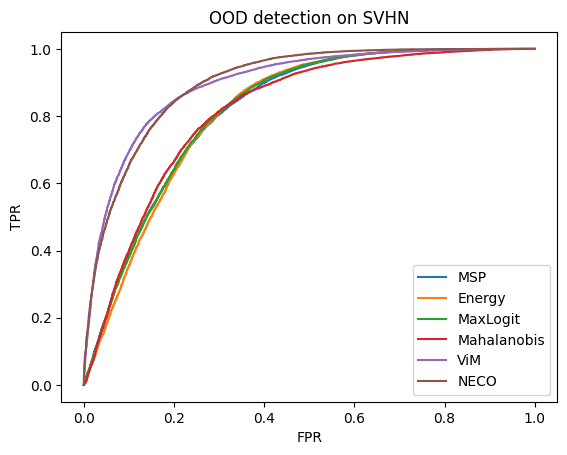

In [ ]:
plt.figure()
plot_roc(score_msp(id_logits), score_msp(ood_logits), "MSP")
plot_roc(score_energy(id_logits), score_energy(ood_logits), "Energy")
plot_roc(score_maxlogit(id_logits), score_maxlogit(ood_logits), "MaxLogit")
plot_roc(
    score_mahalanobis(id_feats, mus, inv_cov),
    score_mahalanobis(ood_feats, mus, inv_cov),
    "Mahalanobis"
)
plot_roc(
    score_vim(id_logits, id_feats, U_orth),
    score_vim(ood_logits, ood_feats, U_orth),
    "ViM"
)
plot_roc(
    -id_scores,
    -svhn_scores,
    "NECO"
)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.title("OOD detection on SVHN")
os.makedirs("results/img", exist_ok=True)
plt.savefig("results/img/OOD_SVHN")
plt.show()

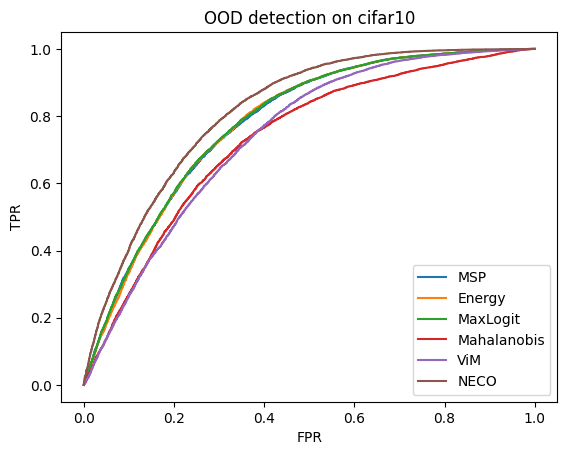

In [154]:
plt.figure()
plot_roc(score_msp(id_logits), score_msp(ood_logits), "MSP")
plot_roc(score_energy(id_logits), score_energy(ood_logits), "Energy")
plot_roc(score_maxlogit(id_logits), score_maxlogit(ood_logits), "MaxLogit")
plot_roc(
    score_mahalanobis(id_feats, mus, inv_cov),
    score_mahalanobis(ood_feats, mus, inv_cov),
    "Mahalanobis"
)
plot_roc(
    score_vim(id_logits, id_feats, U_orth),
    score_vim(ood_logits, ood_feats, U_orth),
    "ViM"
)
plot_roc(
    -id_scores,
    -c10_scores,
    "NECO"
)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.title("OOD detection on cifar10")
os.makedirs("results/img", exist_ok=True)
plt.savefig("results/img/OOD_cifar10")
plt.show()

C:\Users\mathi\AppData\Local\Temp\ipykernel_9552\3606596715.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoints/checkpoint_epoch_90.pth"

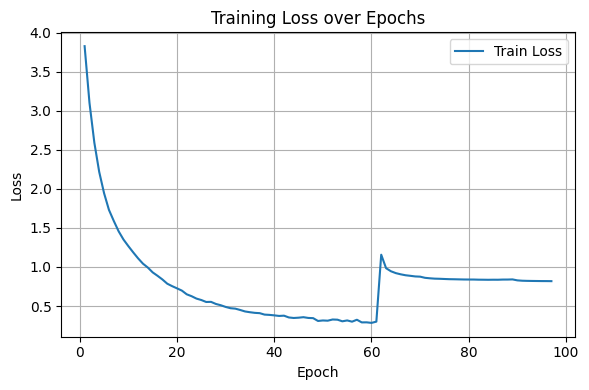

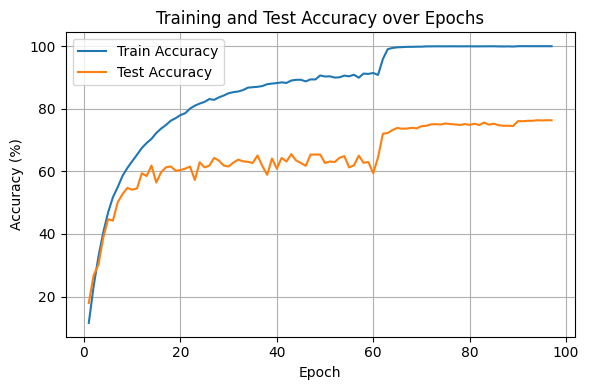

In [156]:
# Charger le checkpoint
checkpoint = torch.load("checkpoints/checkpoint_epoch_90.pth", map_location="cpu")

train_losses = checkpoint["train_losses"]
train_accs = checkpoint["train_accs"]
test_accs = checkpoint["test_accs"]

epochs = range(1, len(train_losses) + 1)

# Dossier de sortie
os.makedirs("results/img", exist_ok=True)

# ---------------------------
# Figure 1 : Loss d'entraînement
# ---------------------------
plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("results/img/training_loss.png", dpi=300)
plt.show()

# ---------------------------
# Figure 2 : Accuracy
# ---------------------------
plt.figure(figsize=(6,4))
plt.plot(epochs, train_accs, label="Train Accuracy")
plt.plot(epochs, test_accs, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Test Accuracy over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("results/img/training_accuracy.png", dpi=300)
plt.show()

In [157]:
training_metrics = {"Train Loss": train_losses, "Train Accuracy": train_accs, "Test Accuracy": test_accs}
training_metrics_df = pd.DataFrame(training_metrics)

In [158]:
training_metrics_df.to_csv("results/training_metrics.csv")